<a href="https://colab.research.google.com/github/BATspock/deeplearning/blob/master/NAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
trainDf = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/train.csv')

In [3]:
trainDf.head()

,Id,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type_of_attack
0,1,0,tcp,other,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,1,0.01,0.0,0.99,1.0,0.0,1.0,0.0,255,1,0.0,1.0,0.00,0.00,0.00,0.0,1.00,1.00,satan.
1,2,0,tcp,http,SF,54540,8314,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,3,3,0.00,0.0,0.00,0.0,1.0,0.0,0.0,178,178,1.0,0.0,0.01,0.00,0.00,0.0,0.01,0.01,back.
2,3,0,tcp,other,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,1,0.03,0.0,0.97,1.0,0.0,1.0,0.0,255,1,0.0,1.0,0.00,0.00,0.00,0.0,1.00,1.00,satan.
3,4,0,icmp,eco_i,SF,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,14,0.00,0.0,0.00,0.0,1.0,0.0,1.0,1,86,1.0,0.0,1.00,0.51,0.00,0.0,0.00,0.00,ipsweep.
4,5,0,tcp,other,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,511,1,0.08,0.0,0.92,1.0,0.0,1.0,0.0,255,1,0.0,1.0,0.00,0.00,0.07,0.0,0.93,1.00,satan.


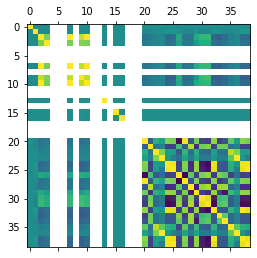

In [4]:
import matplotlib.pyplot as plt

plt.matshow(trainDf.corr())
plt.show()

In [5]:
corr = trainDf[1:].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1126: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/usr/local/lib/python3.7/dist-packages/pandas/io/formats/style.py:1127: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,Id,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
Id,1.00,0.01,-0.02,-0.00,nan,nan,nan,-0.02,nan,-0.01,-0.02,nan,nan,-0.00,nan,0.01,0.01,nan,nan,nan,0.02,0.00,0.01,0.02,0.00,-0.00,-0.01,0.01,0.01,-0.00,-0.01,-0.00,0.01,0.00,-0.01,0.01,0.02,0.01,-0.00
duration,0.01,1.00,-0.03,-0.02,nan,nan,nan,-0.03,nan,-0.00,-0.03,nan,nan,-0.00,nan,-0.00,-0.00,nan,nan,nan,-0.05,-0.05,-0.00,-0.01,0.07,0.06,0.04,-0.04,-0.07,0.05,-0.06,-0.07,0.07,0.04,-0.04,-0.01,-0.01,0.07,0.06
src_bytes,-0.02,-0.03,1.00,0.60,nan,nan,nan,0.99,nan,0.82,0.99,nan,nan,-0.00,nan,-0.00,-0.00,nan,nan,nan,-0.21,-0.17,-0.09,-0.05,-0.30,-0.25,0.23,-0.22,-0.18,0.24,0.32,0.34,-0.32,-0.36,-0.27,-0.12,-0.06,-0.29,-0.28
dst_bytes,-0.00,-0.02,0.60,1.00,nan,nan,nan,0.60,nan,0.62,0.59,nan,nan,-0.00,nan,-0.00,0.00,nan,nan,nan,-0.16,-0.12,-0.07,-0.04,-0.23,-0.20,0.17,-0.17,-0.14,0.11,0.25,0.26,-0.24,-0.26,-0.20,-0.10,-0.04,-0.23,-0.22
land,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
wrong_fragment,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
urgent,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
hot,-0.02,-0.03,0.99,0.60,nan,nan,nan,1.00,nan,0.81,0.99,nan,nan,-0.00,nan,-0.00,-0.00,nan,nan,nan,-0.20,-0.17,-0.09,-0.05,-0.30,-0.25,0.22,-0.22,-0.18,0.24,0.32,0.34,-0.32,-0.36,-0.27,-0.12,-0.05,-0.29,-0.28
num_failed_logins,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
logged_in,-0.01,-0.00,0.82,0.62,nan,nan,nan,0.81,nan,1.00,0.80,nan,nan,0.03,nan,0.02,0.02,nan,nan,nan,-0.25,-0.16,-0.11,-0.07,-0.37,-0.33,0.27,-0.26,-0.24,0.12,0.38,0.40,-0.38,-0.42,-0.31,-0.16,-0.07,-0.36,-0.35


In [6]:
import numpy as np

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,Id,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
Id,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
duration,0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
src_bytes,-0.02,-0.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
dst_bytes,-0.00,-0.02,0.60,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
land,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
wrong_fragment,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
urgent,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
hot,-0.02,-0.03,0.99,0.60,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
num_failed_logins,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
logged_in,-0.01,-0.00,0.82,0.62,nan,nan,nan,0.81,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [7]:
trainDf.nunique()

Id                             12989
duration                          29
protocol_type                      3
service                           61
flag                               9
src_bytes                        179
dst_bytes                        260
land                               1
wrong_fragment                     1
urgent                             1
hot                                3
num_failed_logins                  1
logged_in                          2
num_compromised                    2
root_shell                         1
su_attempted                       1
num_root                           2
num_file_creations                 1
num_shells                         2
num_access_files                   2
num_outbound_cmds                  1
is_host_login                      1
is_guest_login                     1
count                            425
srv_count                         54
serror_rate                       40
srv_serror_rate                   10
r

In [8]:
trainDf = trainDf.loc[:, trainDf.nunique() != 1]

In [9]:
trainDf['type_of_attack'].value_counts()

ipsweep.      5318
satan.        3711
portsweep.    1999
back.         1400
normal.        561
Name: type_of_attack, dtype: int64

In [10]:
trainDf.shape

(12989, 33)

In [11]:
corr = trainDf.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

,Id,duration,src_bytes,dst_bytes,hot,logged_in,num_compromised,num_root,num_shells,num_access_files,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
Id,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
duration,0.01,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
src_bytes,-0.02,-0.03,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
dst_bytes,-0.00,-0.02,0.60,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
hot,-0.02,-0.03,0.99,0.60,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
logged_in,-0.01,-0.00,0.82,0.62,0.81,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
num_compromised,-0.02,-0.03,0.99,0.59,0.99,0.80,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
num_root,-0.00,-0.00,-0.00,-0.00,-0.00,0.03,0.04,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
num_shells,0.01,-0.00,-0.00,-0.00,-0.00,0.02,-0.00,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
num_access_files,0.01,-0.00,-0.00,0.00,-0.00,0.02,-0.00,-0.00,-0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [12]:
trainDf['protocol_type'].isna().any()

False

In [13]:
Id = trainDf.pop('Id')
toa = trainDf.pop('type_of_attack')

In [14]:
#trainDf.drop(['Id', 'type_of_attack'], axis = 1).shape
trainDf.shape

(12989, 31)

In [15]:
total_columns = list(trainDf.columns)
len(total_columns)

31

In [16]:
number_columns = list(trainDf.select_dtypes('number').columns)
len(number_columns)

28

In [17]:
trainDf_X = trainDf[number_columns]

In [18]:
trainDf_X.head()

,duration,src_bytes,dst_bytes,hot,logged_in,num_compromised,num_root,num_shells,num_access_files,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,0,0,0,0,0,0,0,511,1,0.01,0.0,0.99,1.0,0.0,1.0,0.0,255,1,0.0,1.0,0.00,0.00,0.00,0.0,1.00,1.00
1,0,54540,8314,2,1,1,0,0,0,3,3,0.00,0.0,0.00,0.0,1.0,0.0,0.0,178,178,1.0,0.0,0.01,0.00,0.00,0.0,0.01,0.01
2,0,0,0,0,0,0,0,0,0,511,1,0.03,0.0,0.97,1.0,0.0,1.0,0.0,255,1,0.0,1.0,0.00,0.00,0.00,0.0,1.00,1.00
3,0,8,0,0,0,0,0,0,0,1,14,0.00,0.0,0.00,0.0,1.0,0.0,1.0,1,86,1.0,0.0,1.00,0.51,0.00,0.0,0.00,0.00
4,0,0,0,0,0,0,0,0,0,511,1,0.08,0.0,0.92,1.0,0.0,1.0,0.0,255,1,0.0,1.0,0.00,0.00,0.07,0.0,0.93,1.00


In [19]:
total_columns, number_columns = set(total_columns), set(number_columns)

In [20]:
nan_columns = total_columns - number_columns

In [21]:
nan_columns

{'flag', 'protocol_type', 'service'}

In [22]:
trainDf['service'].value_counts()

eco_i       4663
other       3400
private     2592
http        1971
ftp_data      33
            ... 
efs            1
X11            1
pop_3          1
http_443       1
Z39_50         1
Name: service, Length: 61, dtype: int64

In [23]:
trainDf['flag'].value_counts()

SF        6925
REJ       3831
RSTR      1793
S0         317
RSTOS0      76
RSTO        36
OTH          5
S2           4
S1           2
Name: flag, dtype: int64

In [24]:
trainDf['protocol_type'].value_counts()

tcp     8052
icmp    4665
udp      272
Name: protocol_type, dtype: int64

In [25]:
from sklearn import preprocessing
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers

In [26]:
protocolType = np.array(trainDf['protocol_type'])
flag  = np.array(trainDf['flag'])
service = np.array(trainDf['service'])


In [27]:
protocolType = np.reshape(protocolType, (protocolType.shape[0], 1))
flag = np.reshape(flag, (flag.shape[0], 1))
service = np.reshape(service, (service.shape[0], 1))

In [28]:
labels = toa.nunique()
labels

5

In [29]:
toa = np.array(toa)
toa = np.reshape(toa, (toa.shape[0],1))

In [30]:
label_encoder = preprocessing.LabelEncoder()
encoded_toa = label_encoder.fit_transform(toa)
encoded_protocolType = label_encoder.fit_transform(protocolType)
encoded_flag = label_encoder.fit_transform(flag)
encoded_service = label_encoder.fit_transform(service)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [31]:
np.unique(encoded_toa), np.unique(encoded_protocolType), np.unique(encoded_flag), np.unique(encoded_service)

(array([0, 1, 2, 3, 4]),
 array([0, 1, 2]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60]))

In [32]:
encoded_toa.shape

(12989,)

In [33]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
encoded_toa = np.reshape(encoded_toa, (encoded_toa.shape[0],1))
Y = enc.fit_transform(encoded_toa)

In [34]:
Y.shape

(12989, 5)

In [35]:
encoded_protocolType = np.reshape(encoded_protocolType, (encoded_protocolType.shape[0],1))
encoded_service = np.reshape(encoded_service, (encoded_service.shape[0],1))
encoded_flag = np.reshape(encoded_flag, (encoded_flag.shape[0],1))

In [36]:
protocolType = enc.fit_transform(encoded_protocolType)
service = enc.fit_transform(encoded_service)
flag = enc.fit_transform(encoded_flag)

In [37]:
protocolType.shape, service.shape, flag.shape

((12989, 3), (12989, 61), (12989, 9))

In [38]:
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler()

# transform training data
X_train = norm.fit_transform(trainDf_X)
type(X_train), type(protocolType), type(flag), type(service)
#protocolType, flag, service = np.array(protocolType), np.array(flag), np.array(service)
protocolType.shape

(12989, 3)

In [39]:
X_train.shape, protocolType.shape, flag.shape, service.shape

((12989, 28), (12989, 3), (12989, 9), (12989, 61))

In [40]:
type(X_train), type(protocolType), type(flag), type(service)

(numpy.ndarray,
 scipy.sparse.csr.csr_matrix,
 scipy.sparse.csr.csr_matrix,
 scipy.sparse.csr.csr_matrix)

In [41]:
pt = protocolType.toarray()
f = flag.toarray()
s = service.toarray()

In [42]:
pt.shape, f.shape

((12989, 3), (12989, 9))

In [43]:
pt[0]

array([0., 1., 0.])

In [44]:
pt_f = np.concatenate((pt, f), axis = 1)

In [45]:
x = np.concatenate((pt_f, s), axis = 1)

In [46]:
x.shape, X_train.shape

((12989, 73), (12989, 28))

In [47]:
X = np.concatenate((x, X_train), axis = 1)

In [48]:
Y = Y.toarray()

In [49]:
X.shape, Y.shape

((12989, 101), (12989, 5))

In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

In [51]:
from sklearn.utils import shuffle

In [52]:
X,Y = shuffle(X,Y)

In [53]:

model = Sequential([
    Dense(units=128, input_shape=(1,101), activation='relu'),
    Dense(units=256, activation='relu'),
    Dense(units=5, activation='softmax')
])

In [54]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 128)            13056     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 256)            33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 5)              1285      
Total params: 47,365
Trainable params: 47,365
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [56]:
model.fit(x=X, y=Y, validation_split=0.33,  batch_size=1024, epochs=50, verbose=2)

Epoch 1/50
9/9 - 3s - loss: 1.2317 - accuracy: 0.7921 - val_loss: 0.8316 - val_accuracy: 0.9170
Epoch 2/50
9/9 - 0s - loss: 0.6170 - accuracy: 0.9224 - val_loss: 0.3787 - val_accuracy: 0.9370
Epoch 3/50
9/9 - 0s - loss: 0.2766 - accuracy: 0.9376 - val_loss: 0.1686 - val_accuracy: 0.9410
Epoch 4/50
9/9 - 0s - loss: 0.1199 - accuracy: 0.9721 - val_loss: 0.0732 - val_accuracy: 0.9928
Epoch 5/50
9/9 - 0s - loss: 0.0539 - accuracy: 0.9948 - val_loss: 0.0382 - val_accuracy: 0.9930
Epoch 6/50
9/9 - 0s - loss: 0.0283 - accuracy: 0.9949 - val_loss: 0.0233 - val_accuracy: 0.9932
Epoch 7/50
9/9 - 0s - loss: 0.0178 - accuracy: 0.9956 - val_loss: 0.0158 - val_accuracy: 0.9944
Epoch 8/50
9/9 - 0s - loss: 0.0124 - accuracy: 0.9963 - val_loss: 0.0120 - val_accuracy: 0.9967
Epoch 9/50
9/9 - 0s - loss: 0.0095 - accuracy: 0.9983 - val_loss: 0.0097 - val_accuracy: 0.9981
Epoch 10/50
9/9 - 0s - loss: 0.0076 - accuracy: 0.9989 - val_loss: 0.0081 - val_accuracy: 0.9991
Epoch 11/50
9/9 - 0s - loss: 0.0063 - a

In [57]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/model.h5')

In [58]:
from keras.models import load_model
Model = load_model('/content/gdrive/MyDrive/Colab Notebooks/model.h5')

In [59]:
Model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 128)            13056     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 256)            33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1, 5)              1285      
Total params: 47,365
Trainable params: 47,365
Non-trainable params: 0
_________________________________________________________________
